### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл)

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

In [2]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 18204307.34it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 342648.75it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6335091.48it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12310306.15it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



# Vanilla GAN

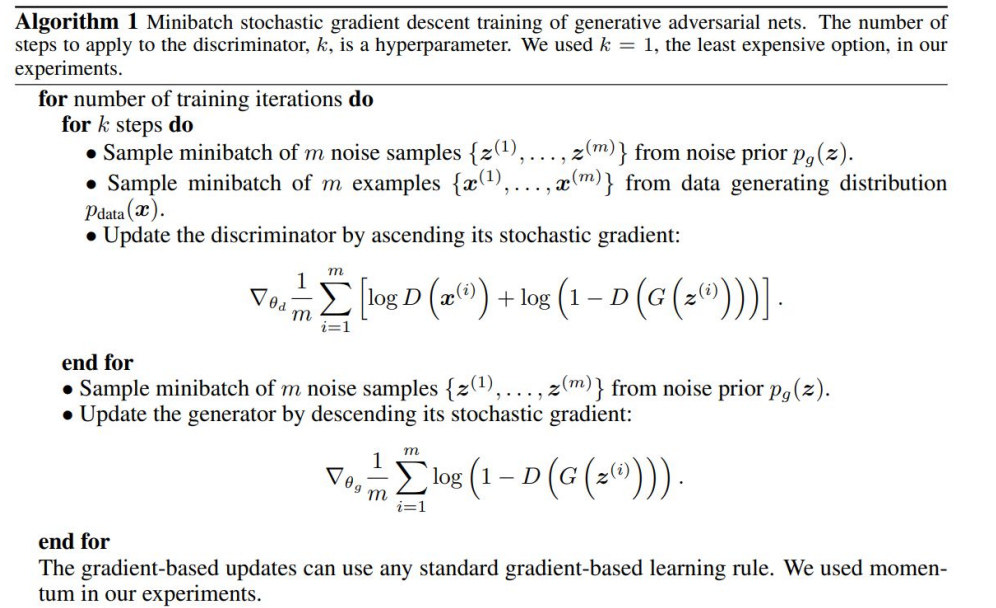

In [ ]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100
config.lr = 0.0001

In [ ]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True)

In [ ]:
len(dataloader)

3750

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
optim_G = optim.Adam(params=generator.parameters(), lr=config.lr)
optim_D = optim.Adam(params=discriminator.parameters(), lr=config.lr)

criterion = nn.BCELoss()

In [ ]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data)
        errD_x = criterion(output.squeeze(), label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output.squeeze(), label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        # torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=config.max_norm)
        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output.squeeze(), label)
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.20 errD_z: 0.15 errG: 2.07
Epoch:1 Iter: 200 errD_x: 0.49 errD_z: 0.25 errG: 1.79
Epoch:1 Iter: 300 errD_x: 0.22 errD_z: 0.14 errG: 2.28
Epoch:1 Iter: 400 errD_x: 0.10 errD_z: 0.15 errG: 2.15
Epoch:1 Iter: 500 errD_x: 0.25 errD_z: 0.09 errG: 2.54
Epoch:1 Iter: 600 errD_x: 0.38 errD_z: 0.05 errG: 3.09
Epoch:1 Iter: 700 errD_x: 0.05 errD_z: 0.06 errG: 3.01
Epoch:1 Iter: 800 errD_x: 0.03 errD_z: 0.09 errG: 2.61
Epoch:1 Iter: 900 errD_x: 0.14 errD_z: 0.31 errG: 1.80
Epoch:1 Iter: 1000 errD_x: 0.24 errD_z: 0.23 errG: 2.01
Epoch:1 Iter: 1100 errD_x: 0.14 errD_z: 0.13 errG: 2.45
Epoch:1 Iter: 1200 errD_x: 0.12 errD_z: 0.31 errG: 1.71
Epoch:1 Iter: 1300 errD_x: 0.21 errD_z: 0.28 errG: 1.70
Epoch:1 Iter: 1400 errD_x: 0.08 errD_z: 0.21 errG: 2.06
Epoch:1 Iter: 1500 errD_x: 0.48 errD_z: 0.37 errG: 1.40
Epoch:1 Iter: 1600 errD_x: 0.46 errD_z: 0.24 errG: 2.17
Epoch:1 Iter: 1700 errD_x: 0.27 errD_z: 0.40 errG: 1.85
Epoch:1 Iter: 1800 errD_x: 0.14 errD_z: 0.22 errG: 2.04
E

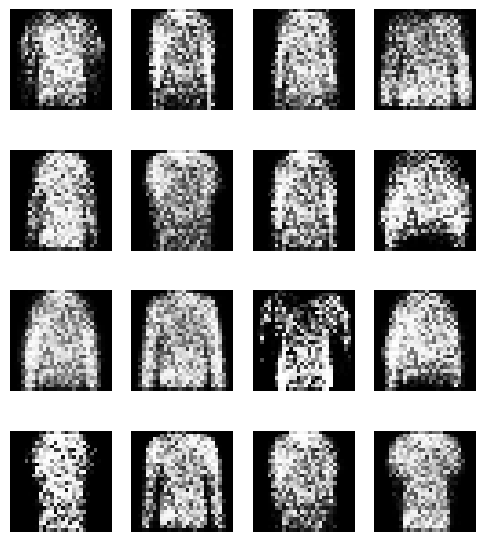

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

# 1 - WGAN with weight clipping

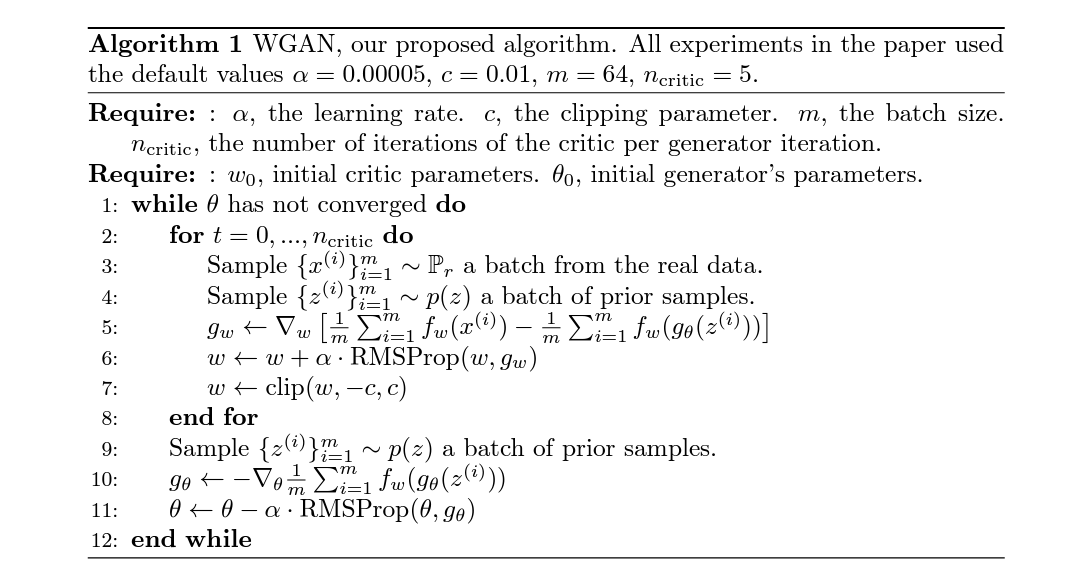

In [3]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 64
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100
config.max_norm = 0.01
config.n_critic = 2
config.lr = 0.00005

In [4]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True, drop_last=True)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
        )
    def forward(self, x):
        return self.model(x)

In [6]:
generator = Generator()
discriminator = Discriminator()

optim_G = optim.RMSprop(params=generator.parameters(), lr=config.lr)
optim_D = optim.RMSprop(params=discriminator.parameters(), lr=config.lr)


input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [7]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        for _ in range(config.n_critic):
            discriminator.zero_grad()
            # real
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data)

            errD_x = output.mean()
            ERRD_x[epoch] += errD_x.item() / config.n_critic

            # fake
            noise.data.normal_(0, 1)
            fake = generator(noise)
            output = discriminator(fake.detach())
            errD_z = output.mean()

            ERRD_z[epoch] += errD_z.item() / config.n_critic

            ERROR_D = -(errD_x - errD_z)
            ERROR_D.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=config.max_norm)
            optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        output = discriminator(fake)
        errG = -output.mean()
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 1.82 errD_z: -3.66 errG: 3.73
Epoch:1 Iter: 200 errD_x: 1.72 errD_z: -7.72 errG: 7.71
Epoch:1 Iter: 300 errD_x: -3.06 errD_z: -14.71 errG: 14.91
Epoch:1 Iter: 400 errD_x: -9.30 errD_z: -23.91 errG: 24.11
Epoch:1 Iter: 500 errD_x: -8.90 errD_z: -28.75 errG: 28.70
Epoch:1 Iter: 600 errD_x: -2.97 errD_z: -26.41 errG: 26.25
Epoch:1 Iter: 700 errD_x: 17.70 errD_z: -16.50 errG: 16.61
Epoch:1 Iter: 800 errD_x: 33.81 errD_z: -5.92 errG: 6.13
Epoch:1 Iter: 900 errD_x: 66.86 errD_z: 15.98 errG: -15.52
Epoch:2 Iter: 100 errD_x: 91.94 errD_z: 29.59 errG: -29.46
Epoch:2 Iter: 200 errD_x: 105.81 errD_z: 59.10 errG: -59.17
Epoch:2 Iter: 300 errD_x: 126.05 errD_z: 80.00 errG: -80.10
Epoch:2 Iter: 400 errD_x: 105.56 errD_z: 53.90 errG: -53.08
Epoch:2 Iter: 500 errD_x: 154.93 errD_z: 103.32 errG: -103.32
Epoch:2 Iter: 600 errD_x: 144.22 errD_z: 117.72 errG: -119.07
Epoch:2 Iter: 700 errD_x: 135.22 errD_z: 68.89 errG: -68.86
Epoch:2 Iter: 800 errD_x: 143.76 errD_z: 79.04 errG: -

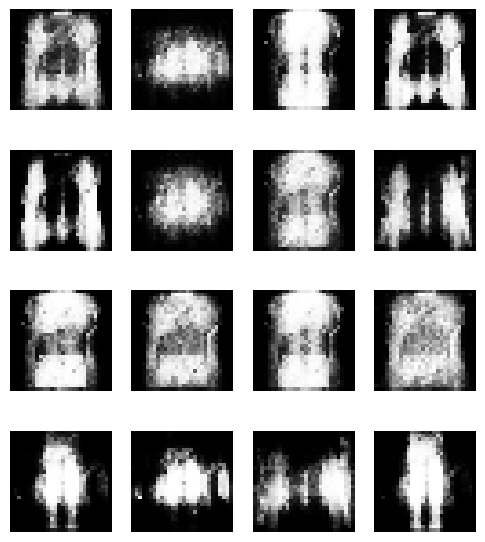

In [8]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

# 2 - WGAN with gradient penalty

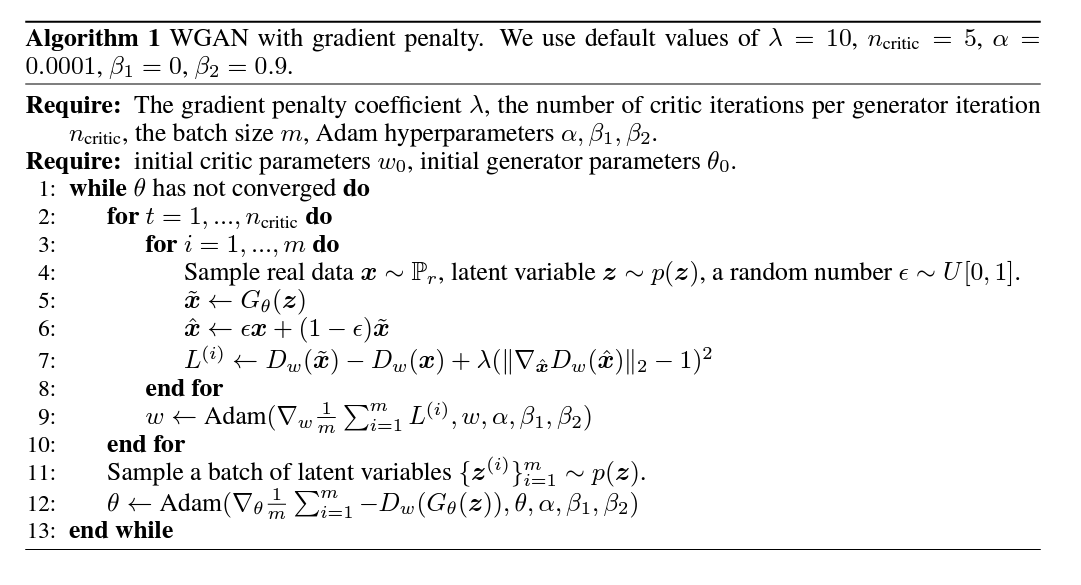

In [9]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 64
config.num_workers = 3
config.num_epochs = 5
config.noise_size = 50
config.print_freq = 100
config.max_norm = 0.01
config.beta_1 = 0
config.beta_2 = 0.9
config.n_critic = 2
config.lr = 0.0001
config.lambda_ = 10

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
    def forward(self, x):
        return self.model(x)

In [11]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True, drop_last=True)
generator = Generator()
discriminator = Discriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=config.lr, betas=(config.beta_1, config.beta_2))
optim_D = optim.Adam(params=discriminator.parameters(), lr=config.lr, betas=(config.beta_1, config.beta_2))


input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [12]:
def grad_penalty(descriminator, real_img, fake_img):
    BS, hidden = real_img.shape
    epsilons = torch.rand((BS, 1)).repeat((1, hidden))
    colaps_img = epsilons * real_img + (1-epsilons) * fake_img
    scores = descriminator(colaps_img)

    grad = torch.autograd.grad(
        inputs=colaps_img,
        outputs=scores,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    norm = torch.norm(input=grad, p=2, dim=1)
    value = torch.mean((norm - 1) ** 2)
    return value


In [13]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        for _ in range(config.n_critic):
            discriminator.zero_grad()
            # real
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data)

            errD_x = output.mean()
            ERRD_x[epoch] += errD_x.item() / config.n_critic

            # fake
            noise.data.normal_(0, 1)
            fake = generator(noise)
            output = discriminator(fake.detach())
            errD_z = output.mean()

            ERRD_z[epoch] += errD_z.item() / config.n_critic
            ERROR_D = -(errD_x - errD_z) + config.lambda_ * grad_penalty(
                discriminator,
                input_data,
                fake,
            )
            ERROR_D.backward(retain_graph=True)
            optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        output = discriminator(fake)
        errG = -output.mean()
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: -1.60 errD_z: -9.22 errG: 9.46
Epoch:1 Iter: 200 errD_x: -1.07 errD_z: -6.41 errG: 6.49
Epoch:1 Iter: 300 errD_x: 2.73 errD_z: -2.17 errG: 2.36
Epoch:1 Iter: 400 errD_x: 4.47 errD_z: 0.26 errG: -0.41
Epoch:1 Iter: 500 errD_x: 4.17 errD_z: -0.29 errG: 0.02
Epoch:1 Iter: 600 errD_x: 4.38 errD_z: 0.51 errG: -0.62
Epoch:1 Iter: 700 errD_x: 4.31 errD_z: 0.66 errG: -0.81
Epoch:1 Iter: 800 errD_x: 4.87 errD_z: 1.72 errG: -1.44
Epoch:1 Iter: 900 errD_x: 4.47 errD_z: 0.99 errG: -1.19
Epoch:2 Iter: 100 errD_x: 2.69 errD_z: -0.09 errG: 0.36
Epoch:2 Iter: 200 errD_x: 3.57 errD_z: 1.13 errG: -1.00
Epoch:2 Iter: 300 errD_x: 3.82 errD_z: 1.36 errG: -1.33
Epoch:2 Iter: 400 errD_x: 2.83 errD_z: 0.39 errG: -0.09
Epoch:2 Iter: 500 errD_x: 3.03 errD_z: 0.48 errG: -0.79
Epoch:2 Iter: 600 errD_x: 2.16 errD_z: -0.23 errG: 0.03
Epoch:2 Iter: 700 errD_x: 3.23 errD_z: 1.00 errG: -0.89
Epoch:2 Iter: 800 errD_x: 3.37 errD_z: 1.15 errG: -1.24
Epoch:2 Iter: 900 errD_x: 1.96 errD_z: 0.02 er

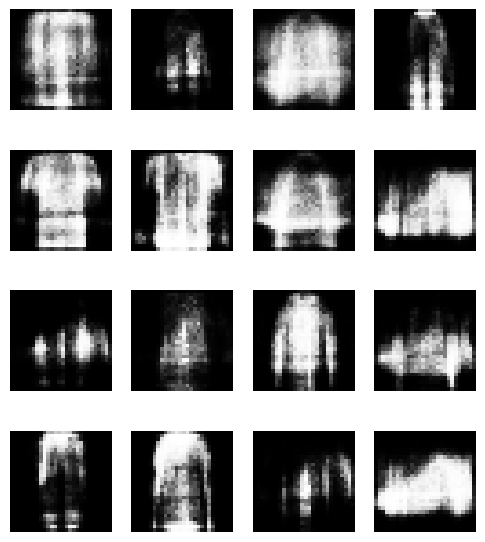

In [14]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

# 3 WGAN with condition label

In [15]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 64
config.num_workers = 3
config.num_epochs = 30
config.noise_size = 100
config.print_freq = 100
config.beta_1 = 0
config.beta_2 = 0.9
config.n_critic = 5
config.lr = 0.0001
config.lambda_ = 10


In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.input_prenet =  nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
        )
        self.label_net = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 50),
        )

        self.final_layer = nn.Sequential(
            nn.Linear(150, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x, label):
        input_hidded = self.input_prenet(x)
        label_hidded = self.label_net(self.label_emb(label))
        return self.final_layer(torch.cat([input_hidded, label_hidded], dim=1))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_emb = nn.Embedding(10, 20)

        self.input_prenet =  nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
        )
        self.label_net = nn.Sequential(
            nn.Linear(20, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 50),
        )

        self.final_layer = nn.Sequential(
            nn.Linear(150, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
        )

    def forward(self, x, label):
        input_hidded = self.input_prenet(x)
        label_hidded = self.label_net(self.label_emb(label))
        return self.final_layer(torch.cat([input_hidded, label_hidded], dim=1))

In [17]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True, drop_last=True)
generator = Generator()
discriminator = Discriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=config.lr, betas=(config.beta_1, config.beta_2))
optim_D = optim.Adam(params=discriminator.parameters(), lr=config.lr, betas=(config.beta_1, config.beta_2))


input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [18]:
def grad_penalty(descriminator, real_img, fake_img, labels=None):
    BS, hidden = real_img.shape
    epsilons = torch.rand((BS, 1)).repeat((1, hidden))
    colaps_img = epsilons * real_img + (1-epsilons) * fake_img
    if labels is not None:
        scores = descriminator(colaps_img, labels)
    else:
        scores = descriminator(colaps_img)

    grad = torch.autograd.grad(
        inputs=colaps_img,
        outputs=scores,
        grad_outputs=torch.ones_like(scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    norm = torch.norm(input=grad, p=2, dim=1)
    value = torch.mean((norm - 1) ** 2)
    return value


In [19]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        for _ in range(config.n_critic):
            discriminator.zero_grad()
            # real
            input_data = images.view(images.shape[0], -1)
            BS = input_data.shape[0]
            output = discriminator(input_data, cat)
            errD_x = output.mean()
            ERRD_x[epoch] += errD_x.item() / config.n_critic

            # fake
            noise.data.normal_(0, 1)
            fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, BS)))
            fake = generator(noise, fake_labels)
            output = discriminator(fake.detach(), fake_labels)
            errD_z = output.mean()

            ERRD_z[epoch] += errD_z.item() / config.n_critic
            ERROR_D = -(errD_x - errD_z) + config.lambda_ * grad_penalty(
                discriminator,
                input_data,
                fake,
                cat,
            )
            ERROR_D.backward(retain_graph=True)
            optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        output = discriminator(fake, fake_labels)
        errG = -output.mean()
        ERRG[epoch] += errG.item()
        errG.backward()

        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1,
                                                                                            errD_x.item(),
                                                                                            errD_z.item(),
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 3.94 errD_z: -0.88 errG: 0.86
Epoch:1 Iter: 200 errD_x: 3.16 errD_z: -2.58 errG: 2.19
Epoch:1 Iter: 300 errD_x: 6.75 errD_z: 0.43 errG: -0.58
Epoch:1 Iter: 400 errD_x: 6.96 errD_z: 1.71 errG: -1.61
Epoch:1 Iter: 500 errD_x: 4.01 errD_z: -0.51 errG: 0.55
Epoch:1 Iter: 600 errD_x: 3.78 errD_z: -1.16 errG: 0.93
Epoch:1 Iter: 700 errD_x: 4.35 errD_z: -0.65 errG: 0.48
Epoch:1 Iter: 800 errD_x: 5.94 errD_z: 0.89 errG: -1.19
Epoch:1 Iter: 900 errD_x: 4.74 errD_z: -0.26 errG: 0.73
Epoch:2 Iter: 100 errD_x: 3.28 errD_z: -0.44 errG: 0.37
Epoch:2 Iter: 200 errD_x: 2.64 errD_z: -1.82 errG: 2.55
Epoch:2 Iter: 300 errD_x: 2.21 errD_z: -1.06 errG: 1.02
Epoch:2 Iter: 400 errD_x: 4.12 errD_z: 1.02 errG: -0.09
Epoch:2 Iter: 500 errD_x: 3.32 errD_z: -0.24 errG: 0.20
Epoch:2 Iter: 600 errD_x: 3.66 errD_z: 0.18 errG: -0.50
Epoch:2 Iter: 700 errD_x: 5.61 errD_z: 2.01 errG: -2.16
Epoch:2 Iter: 800 errD_x: 4.91 errD_z: 1.09 errG: -0.99
Epoch:2 Iter: 900 errD_x: 6.17 errD_z: 2.66 errG

0: T-shirt/top

1: Trouser

2: Pullover

3: Dress

4: Coat

5: Sandal

6: Shirt

7: Sneaker

8: Bag

9: Ankle boot

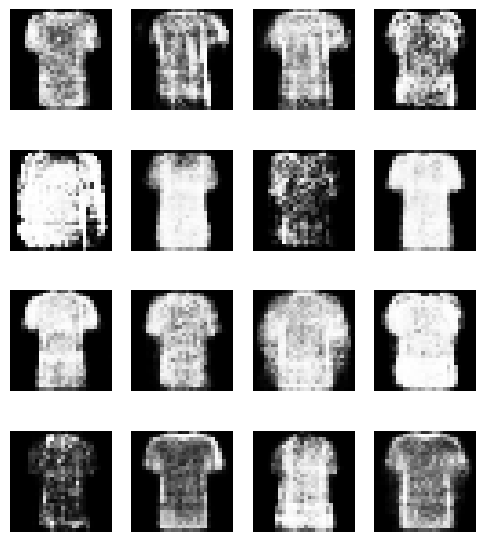

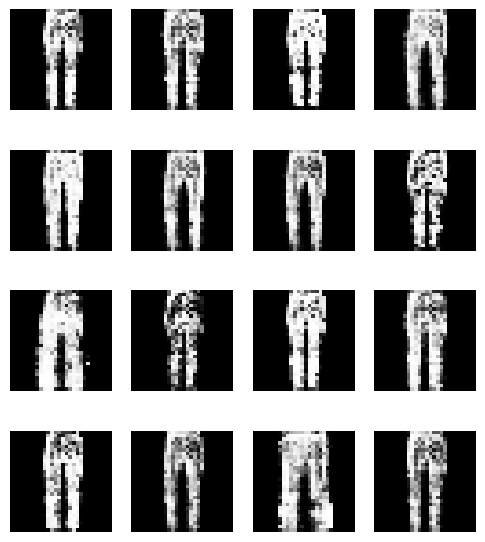

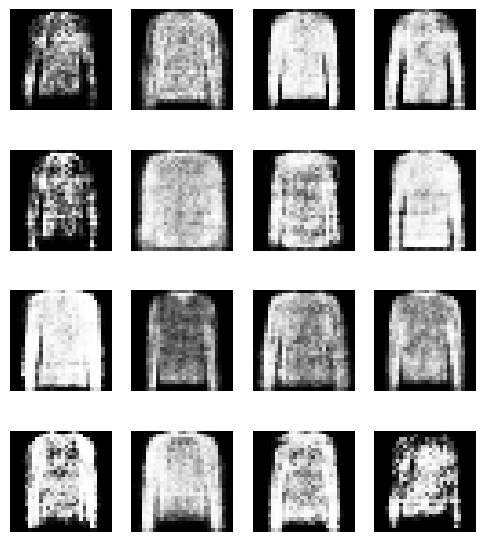

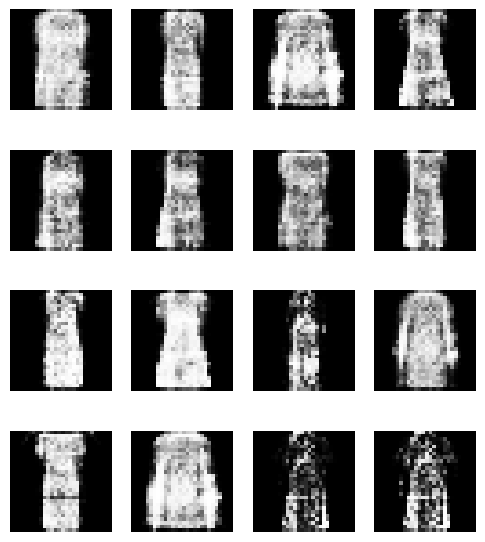

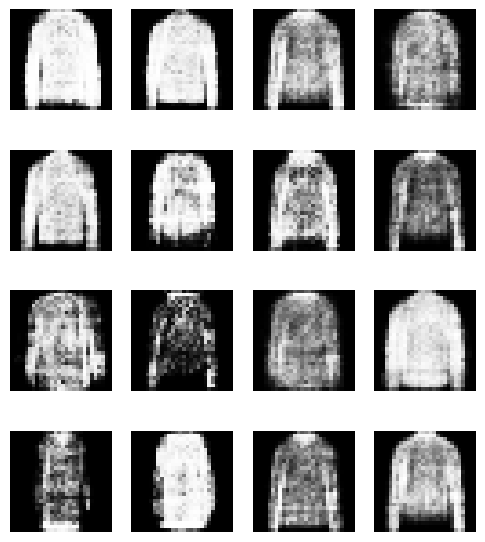

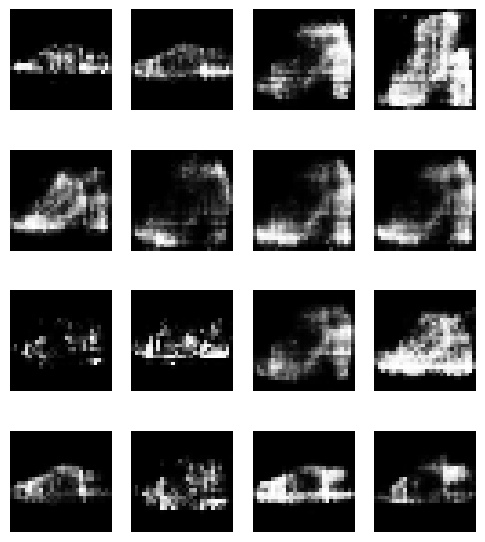

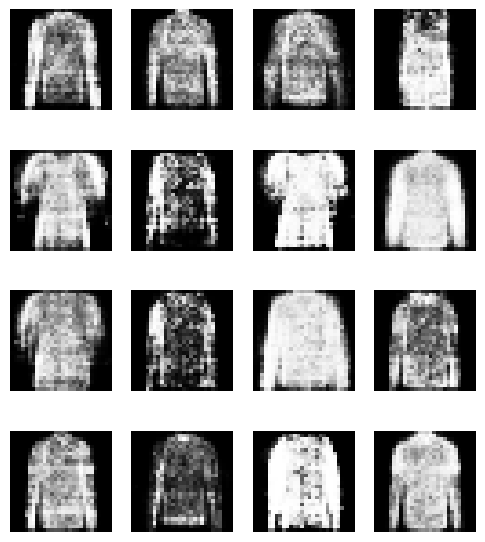

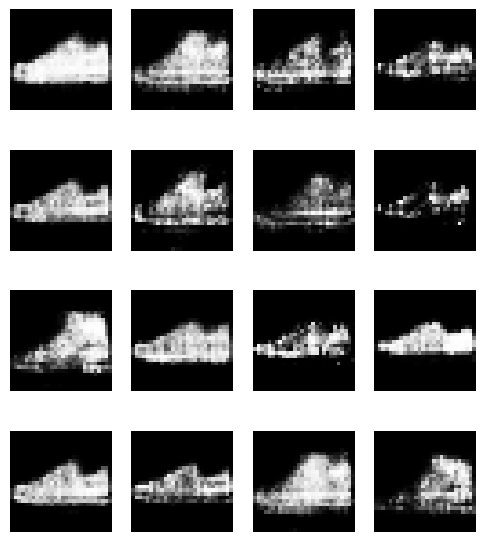

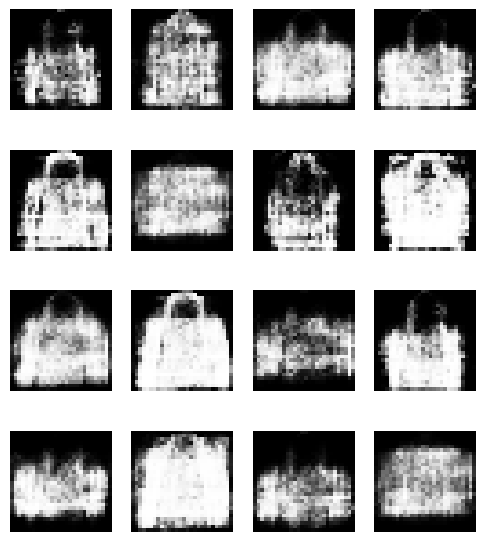

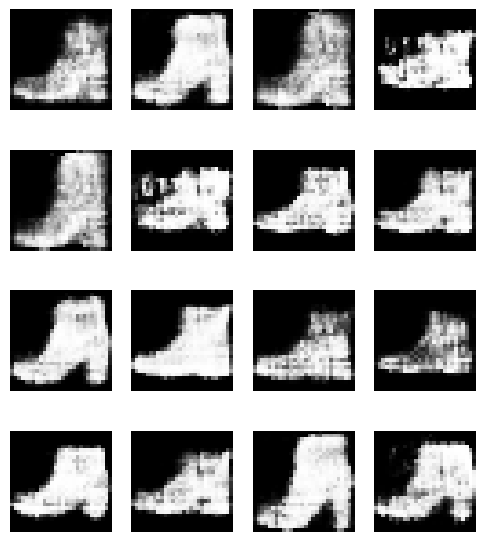

In [20]:
for i in range(10):
    noise.data.normal_(0, 1)
    fake_lables = torch.LongTensor([i]*noise.shape[0])
    fake = generator(noise, fake_lables)

    plt.figure(figsize=(6, 7))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')

WGAN + gradient penalty + condition penalty
работает отлично, также для герепации можно выбирать метку